In [171]:
pip install openai==0.28

  Attempting uninstall: openai
    Found existing installation: openai 1.75.0
    Uninstalling openai-1.75.0:
      Successfully uninstalled openai-1.75.0
Note: you may need to restart the kernel to use updated packages.


# Comparative Analysis of PageRank, HITS, and HITS Variations

This document presents a numerical analysis comparing PageRank, HITS (Hyperlink-Induced Topic Search), and two variations of HITS: Randomised-HITS and Subspace-HITS. The analysis is performed on a dataset of Singapore attractions from TripAdvisor.

## Table of Contents
1. [Introduction](#introduction)
2. [Small Graph Example](#small-graph-example)
3. [Singapore TripAdvisor Dataset](#singapore-tripadvisor-dataset)
4. [Algorithm Implementations](#algorithm-implementations)
   - [PageRank](#pagerank)
   - [HITS](#hits)
   - [Randomised-HITS](#randomised-hits)
   - [Subspace-HITS](#subspace-hits)
5. [Comparative Analysis](#comparative-analysis)
   - [Performance Metrics](#performance-metrics)
   - [Correlation Analysis](#correlation-analysis)
   - [Score Distributions](#score-distributions)
6. [Top Attractions by Algorithm](#top-attractions-by-algorithm)
7. [Conclusion](#conclusion)

## Introduction

Link analysis algorithms like PageRank and HITS are fundamental to web search and recommendation systems. This analysis explores these algorithms and two HITS variations to understand their differences and similarities when applied to tourism data.

## Small Graph Example

We begin with a small directed graph of Singapore attractions to illustrate the basic concepts:

In [156]:
import networkx as nx

G_small = nx.DiGraph()
G_small.add_edges_from([
    ("Marina Bay Sands", "Gardens by the Bay"),
    ("Gardens by the Bay", "Singapore Zoo"),
    ("Singapore Zoo", "Marina Bay Sands"),
    ("Chinatown", "Gardens by the Bay"),
    ("Sentosa", "Singapore Zoo"),
    ("Marina Bay Sands", "Sentosa"),
])

pagerank_small = nx.pagerank(G_small, alpha=0.85)
hubs_small, auth_small = nx.hits(G_small)

print("Small Graph PageRank Scores:\n", pagerank_small)
print("Small Graph Hub Scores:\n", hubs_small)
print("Small Graph Authority Scores:\n", auth_small)

Small Graph PageRank Scores:
 {'Marina Bay Sands': 0.3039150222221387, 'Gardens by the Bay': 0.1846648588588815, 'Singapore Zoo': 0.32225526006009864, 'Chinatown': 0.030000000000000006, 'Sentosa': 0.1591648588588815}
Small Graph Hub Scores:
 {'Marina Bay Sands': 0.6180339887498949, 'Gardens by the Bay': -2.4926059914975058e-17, 'Singapore Zoo': 0.0, 'Chinatown': 0.38196601125010515, 'Sentosa': -2.4926059914975058e-17}
Small Graph Authority Scores:
 {'Marina Bay Sands': 0.0, 'Gardens by the Bay': 0.6180339887498948, 'Singapore Zoo': -4.033121214804596e-17, 'Chinatown': -4.033121214804596e-17, 'Sentosa': 0.3819660112501052}


This example demonstrates how PageRank assigns importance based on the link structure, while HITS distinguishes between hubs (pages that link to many authorities) and authorities (pages that are linked to by many hubs).

## Singapore TripAdvisor Dataset

The main analysis uses a dataset of TripAdvisor reviews for Singapore attractions:

In [157]:
import pandas as pd, networkx as nx

wb = "SIN_TripAdvisor.xlsx"
reviews = pd.read_excel(
    wb,
    sheet_name="SIN_TripAdvisor1",
    parse_dates=["Date"],
    dtype={"Name": "string"}
)

reviews = reviews.rename(
    columns={
        "Date": "review_date",
        "Hotel Name": "attraction",
        "Name": "user_id"
    }
)

# keep users who reviewed >1 attraction
freq = reviews["user_id"].value_counts()
reviews = reviews[reviews["user_id"].isin(freq[freq > 1].index)]

# build weighted directed edges
edges = {}
for uid, grp in reviews.sort_values("review_date").groupby("user_id"):
    seq = grp["attraction"].tolist()
    for a, b in zip(seq, seq[1:]):
        edges[(a, b)] = edges.get((a, b), 0) + 1

G_sg = nx.DiGraph()
G_sg.add_weighted_edges_from([(u, v, w) for (u, v), w in edges.items()])
print(nx.number_of_nodes(G_sg), "nodes", nx.number_of_edges(G_sg), "edges")

27 nodes 606 edges


The dataset is processed to create a directed graph where:
- Nodes represent attractions
- Edges represent transitions between attractions (when a user reviews one attraction after another)
- Edge weights represent the frequency of these transitions

## Algorithm Implementations

### PageRank

PageRank, developed by Google founders, models a random surfer who follows links with probability α and teleports randomly with probability (1-α):

In [158]:
pagerank_sg = nx.pagerank(G_sg, alpha=0.85, weight="weight")

### HITS

HITS (Hyperlink-Induced Topic Search) computes two scores for each node:
- Hub score: measures how well a node points to good authorities
- Authority score: measures how many good hubs point to a node

In [159]:
hubs_sg, auth_sg = nx.hits(G_sg, max_iter=200, tol=1e-8, normalized=True)

### Randomised-HITS

Randomised-HITS (Ng et al., 2001) adds teleportation to the authority update step, similar to PageRank:

In [160]:
def randomised_hits(G, eps=0.15, max_iter=200, tol=1e-8):
    """Randomised‑HITS (Ng et al., 2001): authority update with teleport."""
    nodes = list(G)
    n = len(nodes)
    A = nx.to_numpy_array(G, nodelist=nodes, weight=None, dtype=float)
    # base HITS matrices
    H = A          # link matrix (hub → authority)
    AtA = A.T @ A  # authority matrix
    # add teleportation to guarantee aperiodicity / irreducibility
    AtA = (1 - eps) * AtA + (eps / n) * np.ones_like(AtA)

    x = np.ones(n) / n
    for k in range(max_iter):
        x_new = AtA @ x
        x_new /= np.linalg.norm(x_new)
        if np.linalg.norm(x_new - x, 1) < tol:
            break
        x = x_new
    auth = {nodes[i]: float(x[i]) for i in range(n)}
    return auth, k + 1

This variation ensures convergence by making the authority matrix aperiodic and irreducible.

### Subspace-HITS

Subspace-HITS restricts the power iteration to the dominant eigensubspace:

In [161]:
def subspace_hits(G, k_sub=1, max_iter=200, tol=1e-8):
    """Subspace‑HITS: power iteration restricted to dominant eigensubspace."""
    nodes = list(G)
    n = len(nodes)
    A = nx.to_numpy_array(G, nodelist=nodes, weight=None, dtype=float)
    M = A.T @ A  # authority matrix
    # obtain dominant eigenvectors via Lanczos / ARPACK (k_sub largest)
    vals, vecs = np.linalg.eigh(M)
    idx = np.argsort(vals)[::-1][:k_sub]
    Q = vecs[:, idx]  # dominant subspace basis

    # project initial vector into subspace
    x = np.ones(n) / n
    x = Q @ (Q.T @ x)
    x /= np.linalg.norm(x)

    for it in range(max_iter):
        x_new = M @ x
        # re‑project to subspace and renormalise
        x_new = Q @ (Q.T @ x_new)
        x_new /= np.linalg.norm(x_new)
        if np.linalg.norm(x_new - x, 1) < tol:
            break
        x = x_new
    auth = {nodes[i]: float(x[i]) for i in range(n)}
    return auth, it + 1

This approach can improve convergence and stability by focusing on the most significant eigenvectors.

## Comparative Analysis

All four algorithms were run on the Singapore attractions graph:

In [162]:
from collections import OrderedDict
import time

results = OrderedDict()

# PageRank
start = time.perf_counter()
pr = nx.pagerank(G_sg, alpha=0.85, weight="weight")
results["PageRank"] = dict(scores=pr, runtime=time.perf_counter() - start, iters="≤200")

# Original HITS (authority vector)
start = time.perf_counter()
_, auth_hits = nx.hits(G_sg, normalized=True)
results["HITS"] = dict(scores=auth_hits, runtime=time.perf_counter() - start, iters="≤200")

# Randomised‑HITS
start = time.perf_counter()
auth_rnd, rnd_iter = randomised_hits(G_sg, eps=0.15)
results["Randomised‑HITS"] = dict(scores=auth_rnd, runtime=time.perf_counter() - start, iters=rnd_iter)

# Subspace‑HITS
start = time.perf_counter()
auth_sub, sub_iter = subspace_hits(G_sg, k_sub=1)
results["Subspace‑HITS"] = dict(scores=auth_sub, runtime=time.perf_counter() - start, iters=sub_iter)

### Performance Metrics

For each algorithm, we recorded:
- Runtime in seconds
- Number of iterations to convergence
- Top-5 attractions by score

In [163]:
# pretty print top‑5 for each
for name, dat in results.items():
    top5 = sorted(dat["scores"].items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"{name} (time {dat['runtime']:.3f}s, iters {dat['iters']}):")
    for node, sc in top5:
        print(f"  {node}: {sc:.4f}")

PageRank (time 0.007s, iters ≤200):
  The Fullerton Hotel Singapore: 0.1371
  Concorde Hotel Singapore: 0.1239
  Raffles Hotel: 0.0804
  Grand Park City Hall: 0.0776
  voco Orchard Singapore, an IHG Hotel: 0.0740
HITS (time 0.004s, iters ≤200):
  Concorde Hotel Singapore: 0.9299
  The Fullerton Hotel Singapore: 0.0117
  Raffles Hotel: 0.0075
  Grand Park City Hall: 0.0066
  Quincy Hotel Singapore By Far East Hospitality: 0.0062
Randomised‑HITS (time 0.002s, iters 6):
  The Fullerton Hotel Singapore: 0.2201
  voco Orchard Singapore, an IHG Hotel: 0.2201
  Carlton City Hotel Singapore: 0.2201
  Quincy Hotel Singapore By Far East Hospitality: 0.2201
  Concorde Hotel Singapore: 0.2167
Subspace‑HITS (time 0.002s, iters 1):
  voco Orchard Singapore, an IHG Hotel: 0.2201
  Carlton City Hotel Singapore: 0.2201
  Quincy Hotel Singapore By Far East Hospitality: 0.2201
  The Fullerton Hotel Singapore: 0.2201
  Concorde Hotel Singapore: 0.2167


### Correlation Analysis

We computed Spearman rank correlations between the scores from different algorithms:

In [164]:
from scipy.stats import spearmanr

algo_names = list(results)
cor_mat = pd.DataFrame(index=algo_names, columns=algo_names, dtype=float)

for a in algo_names:
    for b in algo_names:
        scores_a = results[a]["scores"]
        scores_b = results[b]["scores"]
        common = list(set(scores_a) & set(scores_b))
        rank_a = [scores_a[n] for n in common]
        rank_b = [scores_b[n] for n in common]
        cor_mat.loc[a, b] = spearmanr(rank_a, rank_b).correlation

print(cor_mat.round(2))

                 PageRank  HITS  Randomised‑HITS  Subspace‑HITS
PageRank             1.00  0.96             0.90           0.89
HITS                 0.96  1.00             0.88           0.88
Randomised‑HITS      0.90  0.88             1.00           1.00
Subspace‑HITS        0.89  0.88             1.00           1.00


This analysis reveals how similar the rankings produced by different algorithms are.

### Score Distributions

We visualized the score distributions for all algorithms on log-log plots:

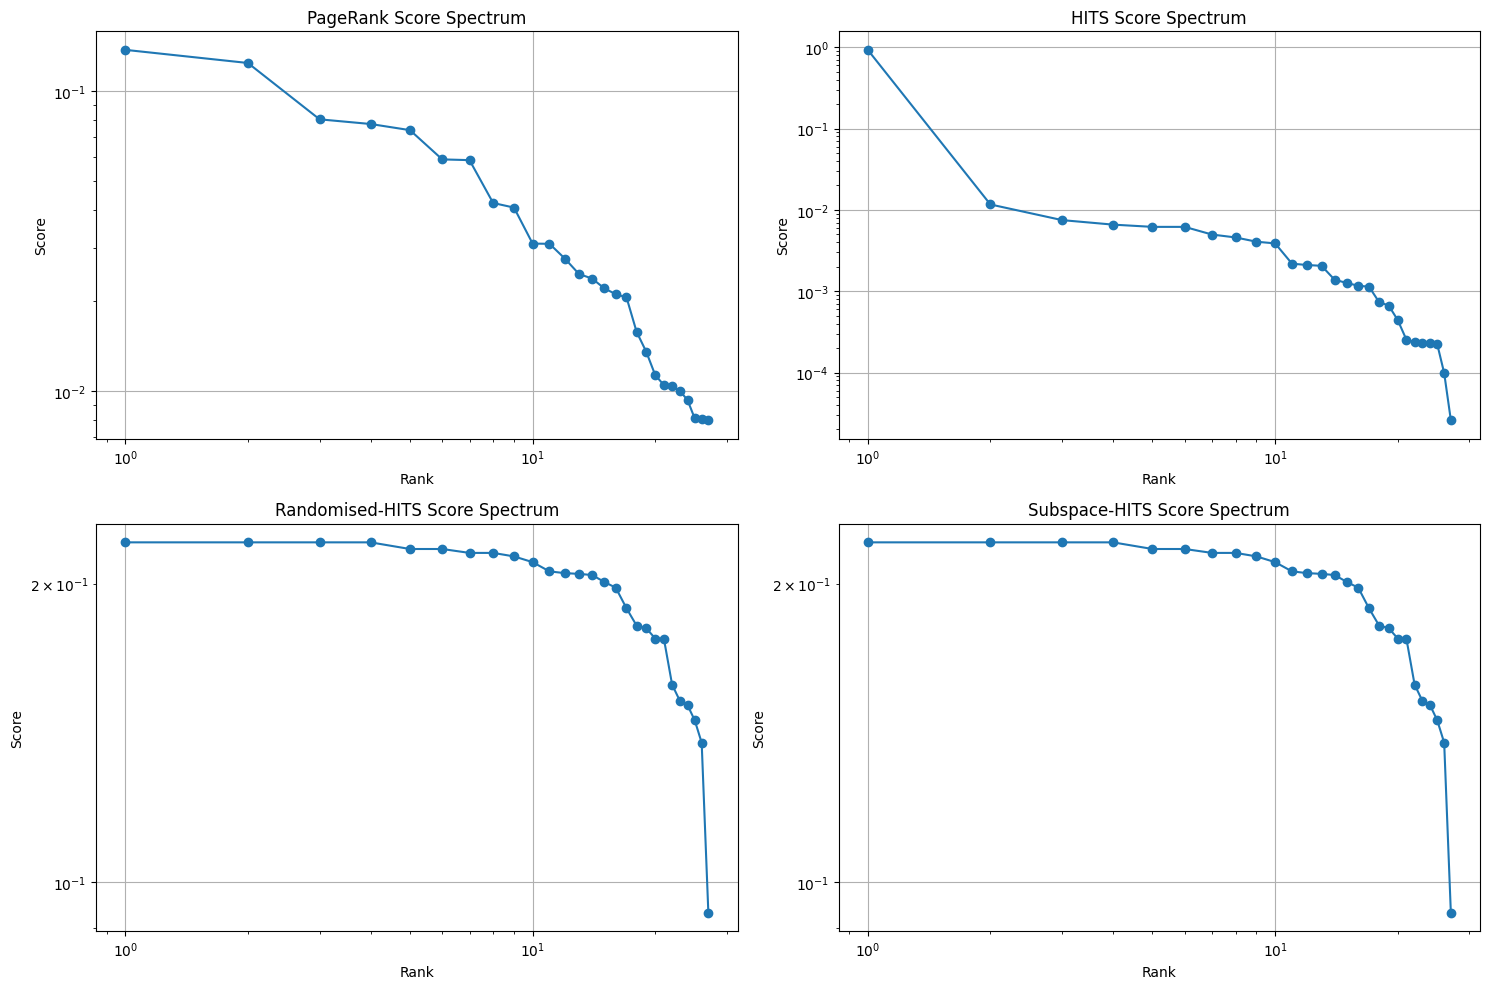

In [165]:
import matplotlib.pyplot as plt

# Plot score distributions for all algorithms
plt.figure(figsize=(15, 10))

for i, (algo, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    scores = sorted(res['scores'].values(), reverse=True)
    plt.loglog(range(1, len(scores) + 1), scores, marker='o')
    plt.title(f"{algo} Score Spectrum")
    plt.xlabel("Rank")
    plt.ylabel("Score")
    plt.grid(True)

plt.tight_layout()
plt.show()

These plots help visualize how quickly the scores decay as rank increases, revealing power-law distributions typical in network analysis.

## Top Attractions by Algorithm

Finally, we visualized the top-10 attractions according to each algorithm:

C:\Users\Zhao Qixian\AppData\Local\Temp\ipykernel_22404\84281587.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


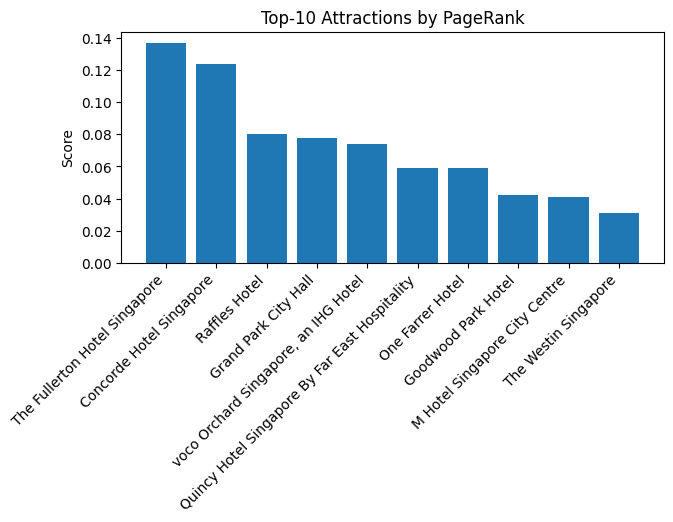

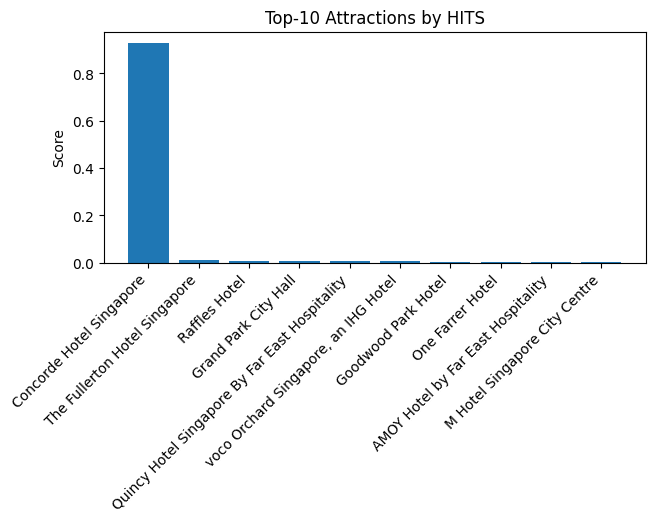

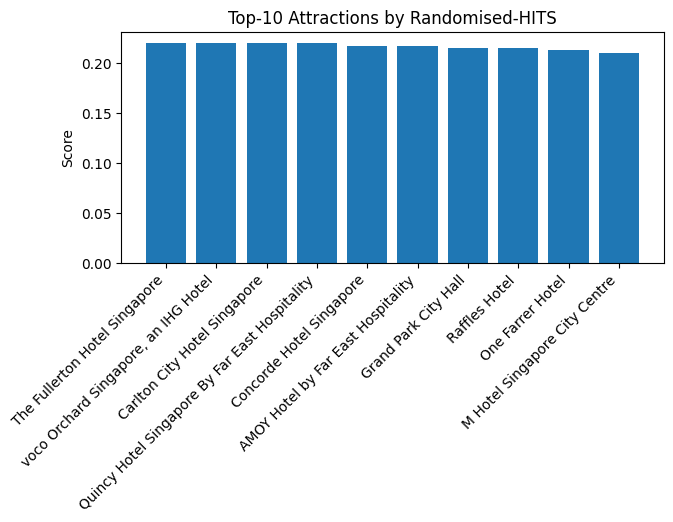

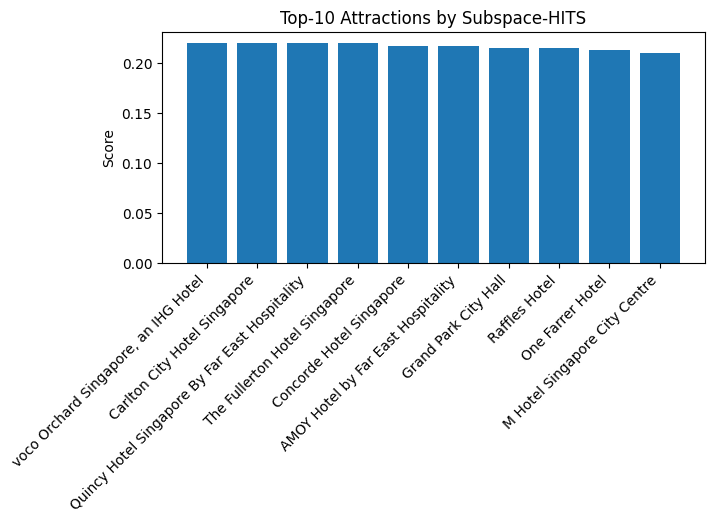

In [166]:
import matplotlib.pyplot as plt

for name, data in results.items():
    top = sorted(data["scores"].items(), key=lambda x: x[1], reverse=True)[:10]
    labels, vals = zip(*top)
    plt.figure(figsize=(7, 3))
    plt.bar(labels, vals)
    plt.title(f"Top‑10 Attractions by {name}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score")
    plt.tight_layout()
plt.show()

## Conclusion

This analysis demonstrates the similarities and differences between PageRank, HITS, and two HITS variations when applied to tourism data:

1. **PageRank** provides a global measure of importance based on the entire link structure.
2. **HITS** separates the concepts of hubs and authorities, providing more nuanced rankings.
3. **Randomised-HITS** improves convergence by adding teleportation, similar to PageRank.
4. **Subspace-HITS** focuses on the dominant eigensubspace for potentially faster and more stable convergence.

The correlation analysis shows which algorithms produce similar rankings, while the score distributions reveal the power-law nature of importance in the attraction network. The top attractions identified by each algorithm provide practical insights for tourism recommendations.

This comparative study helps understand the strengths and characteristics of different link analysis algorithms, which can inform their application in recommendation systems, search engines, and other network analysis tasks.

In [ ]:
# ─── Cell 1: imports + one‐time graph + embeddings setup ───
import os
import pickle
import pandas as pd
import networkx as nx
import numpy as np
from openai import OpenAI

API_KEY = ""
EMBED_MODEL = "text-embedding-ada-002"
EMBED_CACHE = "node_embeddings.pkl"

client = OpenAI(api_key=API_KEY)

def get_embedding(text):
    resp = client.embeddings.create(model=EMBED_MODEL, input=[text])
    return np.array(resp.data[0].embedding)

# load or init cache
if os.path.exists(EMBED_CACHE):
    with open(EMBED_CACHE, "rb") as f:
        node_embeddings = pickle.load(f)
else:
    node_embeddings = {}

# build the graph
wb = "SIN_TripAdvisor.xlsx"
reviews = pd.read_excel(wb, sheet_name="SIN_TripAdvisor1", parse_dates=["Date"], dtype={"Name":"string"})
reviews.rename(columns={"Date":"review_date","Hotel Name":"attraction","Name":"user_id"}, inplace=True)
freq = reviews["user_id"].value_counts()
reviews = reviews[reviews["user_id"].isin(freq[freq>1].index)]

edges = {}
for uid, grp in reviews.sort_values("review_date").groupby("user_id"):
    seq = grp["attraction"].tolist()
    for a, b in zip(seq, seq[1:]):
        edges[(a,b)] = edges.get((a,b),0)+1

G = nx.DiGraph()
G.add_weighted_edges_from((u,v,w) for (u,v),w in edges.items())

# embed all nodes once
missing = [n for n in G.nodes if n not in node_embeddings]
if missing:
    resp = client.embeddings.create(model=EMBED_MODEL, input=missing)
    for node, emb in zip(missing, resp.data):
        node_embeddings[node] = np.array(emb.embedding)
    with open(EMBED_CACHE, "wb") as f:
        pickle.dump(node_embeddings, f)

# compute “original” PageRank once
pr_orig = nx.pagerank(G, alpha=0.85, weight="weight")


In [197]:
# ─── After computing pr_orig ───

# 1) Basic graph stats
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 2) Embedding cache size
print(f"Embeddings cached: {len(node_embeddings)} entries")

# 3) PageRank summary
top5 = sorted(pr_orig.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 attractions by original PageRank:")
for i, (place, score) in enumerate(top5, start=1):
    print(f"  {i}. {place} ({score:.4f})")

# 4) PageRank distribution stats
scores = np.array(list(pr_orig.values()))
print(f"PR score — min: {scores.min():.6f}, max: {scores.max():.6f}, "
      f"mean: {scores.mean():.6f}, std: {scores.std():.6f}")


Graph: 27 nodes, 606 edges
Embeddings cached: 27 entries
Top 5 attractions by original PageRank:
  1. The Fullerton Hotel Singapore (0.1371)
  2. Concorde Hotel Singapore (0.1239)
  3. Raffles Hotel (0.0804)
  4. Grand Park City Hall (0.0776)
  5. voco Orchard Singapore, an IHG Hotel (0.0740)
PR score — min: 0.007991, max: 0.137052, mean: 0.037037, std: 0.034320


In [195]:
# ─── Cell 2: query + descriptions ───
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def describe_place(place: str, query: str) -> str:
    """Ask the LLM to explain in one sentence why this place matches the user's query."""
    resp = client.chat.completions.create(
        model="gpt-4o-mini",  # or another chat model you have access to
        messages=[
            {"role": "system", "content": (
                "You are a succinct assistant that, given a user’s travel query "
                "and a place name, returns exactly one sentence explaining why "
                "that place would satisfy the query."
            )},
            {"role": "user", "content": (
                f"User query: “{query}”\n"
                f"Place: “{place}”\n"
                "Write one concise sentence explaining why this place fits the query."
            )}
        ]
    )
    return resp.choices[0].message.content.strip()

def run_query(query: str):
    # 1) build personalization
    q_emb = get_embedding(query)
    sims = {
        n: float(np.dot(q_emb, emb) /
                 (np.linalg.norm(q_emb) * np.linalg.norm(emb)))
        for n, emb in node_embeddings.items()
    }
    mn = min(sims.values())
    for n in sims: sims[n] -= mn
    total = sum(sims.values()) or 1.0
    p = {n: sims[n]/total for n in sims}

    # 2) personalized PageRank
    pr_pers = nx.pagerank(G, alpha=0.85, weight="weight", personalization=p)

    # 3) compute stats & top‑10
    stats = [
        (n,
         pr_orig[n],
         pr_pers[n],
         pr_pers[n] - pr_orig[n])
        for n in G.nodes
    ]
    top10 = sorted(stats, key=lambda x: x[1], reverse=True)[:10]

    # 4) build rank maps
    orig_order = sorted(pr_orig, key=pr_orig.get, reverse=True)
    pers_order = sorted(pr_pers, key=pr_pers.get, reverse=True)
    orig_rank = {n: i+1 for i, n in enumerate(orig_order)}
    pers_rank = {n: i+1 for i, n in enumerate(pers_order)}

    # 5) plot
    names, origs, pers = zip(*[(t[0], t[1], t[2]) for t in top10])
    x = np.arange(len(names)); w = 0.35
    fig, ax = plt.subplots()
    ax.bar(x - w/2, origs, w, label="Orig")
    ax.bar(x + w/2, pers, w, label="Pers")
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.legend(); plt.tight_layout(); plt.show()

    # 6) print extended table + descriptions
    print(
        f"{'O#':>3} {'P#':>3} {'Attraction':<30} {'Orig':>8} {'Pers':>8} "
        f"{'ΔScore':>8} {'ΔRank':>7} {'%ΔScore':>8}"
    )
    for node, orig_score, pers_score, delta_score in top10:
        o_r = orig_rank[node]
        p_r = pers_rank[node]
        delta_rank = o_r - p_r
        pct_score = (delta_score / orig_score * 100) if orig_score else 0.0
        desc = describe_place(node, query)
        print(
            f"{o_r:3d} {p_r:3d} {node:<30} "
            f"{orig_score:8.4f} {pers_score:8.4f} "
            f"{delta_score:8.4f} {delta_rank:7d} {pct_score:8.1f}%\n"
            f"    ↳ {desc}\n"
        )


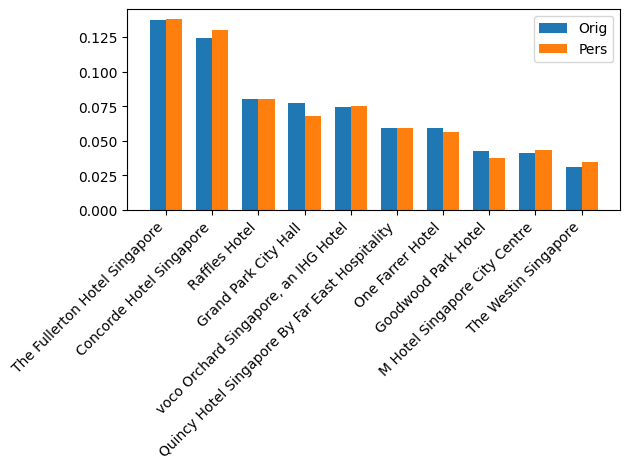

 O#  P# Attraction                         Orig     Pers   ΔScore   ΔRank  %ΔScore
  1   1 The Fullerton Hotel Singapore    0.1371   0.1383   0.0012       0      0.9%
    ↳ The Fullerton Hotel Singapore offers a romantic riverside setting and elegant dining options, making it a perfect spot for a memorable date near NTU.

  2   2 Concorde Hotel Singapore         0.1239   0.1300   0.0061       0      4.9%
    ↳ Concorde Hotel Singapore offers a romantic ambiance and fine dining options, making it an ideal spot for a cozy date near NTU.

  3   3 Raffles Hotel                    0.0804   0.0804  -0.0000       0     -0.0%
    ↳ Raffles Hotel offers a romantic and luxurious setting with its historic charm and elegant dining options, perfect for a memorable date near NTU.

  4   5 Grand Park City Hall             0.0776   0.0678  -0.0098      -1    -12.6%
    ↳ Grand Park City Hall offers a romantic atmosphere with elegant dining options and proximity to charming cultural attractions, making

In [201]:
run_query("I want a place to date near NTU.")